In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("/Users/wilka/git/research/jaxneurorl")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [99]:
# !pip install google-cloud-storage
# !pip install git+https://github.com/wcarvalho/nicewebrl --no-deps
# !pip install ipywidgets
# !pip install polars
# !pip install nicegui

In [100]:
import jax
import jax.numpy as jnp
import functools
from functools import partial
import pandas as pd
import numpy as np
from pprint import pprint
import glob
from glob import glob
import matplotlib.pyplot as plt
import polars as pl
from tqdm.notebook import tqdm

from projects.humansf import data_loading
from projects.humansf import housemaze_analysis
from projects.humansf import data_loading
from projects.humansf import housemaze_trainer
from projects.humansf import housemaze_experiments
from projects.humansf import networks
from projects.humansf import dataframe
from housemaze.human_dyna import mazes

from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import multitask_env as maze
from jaxneurorl import launcher
from jaxneurorl.agents import value_based_basics as vbb


from projects.humansf import download_data

In [101]:
# data_dir = '/n/holylfs06/LABS/kempner_fellow_wcarvalho/results/jaxrl_result/housemaze_trainer'
data_dir = '/Users/wilka/git/research/results/human_dyna'

In [102]:
# experiments = [
#    'exp1_block1',
#    'exp1_block2',
#    'exp1_block3',
#    'exp1_block4',
# ]
dummy_env_params = housemaze_analysis.get_params(mazes.big_practice_maze)
dummy_rng = jax.random.PRNGKey(42)
task_runner = maze.TaskRunner(task_objects=housemaze_analysis.task_objects)
env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=200,
)
env = utils.AutoResetWrapper(env)
nenvs=25
example_timestep = env.reset(dummy_rng, dummy_env_params)

In [103]:
from housemaze.human_dyna import sf_task_runner

task_runner_sf = sf_task_runner.TaskRunner(
    task_objects=housemaze_analysis.task_objects,
    vis_coeff=0.1,
    radius=5)
sf_env = maze.HouseMaze(
    task_runner=task_runner_sf,
    num_categories=200,
)
sf_env = utils.AutoResetWrapper(sf_env)


# Universal Successor Feature Approximators

In [108]:
exp = 'exp2'
path = download_data.sf_dir
paths = f'{data_dir}/model_data/{path}/*'
paths = glob(paths)
paths

path = paths[0]
seed = path.split('/')[-1].split("=")[-1]
algorithm = data_loading.load_algorithm(
    path=path,
    name='usfa',
    make_fns=functools.partial(
        housemaze_trainer.get_sf_fns,
        env=sf_env,
        env_params=dummy_env_params),
    env=sf_env,
    example_env_params=dummy_env_params,
    nenvs=nenvs,
    config=dict(EVAL_TASK_SUPPORT='train')
)
df, episodes = housemaze_analysis.get_algorithm_data(
    algorithm=algorithm,
    exp=exp,
    overwrite=True,
    extra_info=dict(seed=seed),
    data_task_runner=task_runner_sf,
    path='/tmp/sf_vid_data'
  )
sf_df = dataframe.EpisodeDataFrame(
    df=df,
    episodes=episodes,
)
sf_df.head()

No file specified for image dict.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


index,eval,algo,exp,room,task,maze_name,seed
u32,bool,str,str,i64,i64,str,str
0,false,"""usfa""","""exp2""",0,26,"""big_m1_maze3""","""1"""
1,true,"""usfa""","""exp2""",0,40,"""big_m1_maze3""","""1"""
2,false,"""usfa""","""exp2""",0,26,"""big_m2_maze2""","""1"""
3,true,"""usfa""","""exp2""",0,40,"""big_m2_maze2""","""1"""
4,false,"""usfa""","""exp2""",0,26,"""big_m2_maze2_offpath""","""1"""


In [109]:
task_runner_sf.task_objects
names = [housemaze_analysis.image_dict['keys'][i] for i in task_runner_sf.task_objects]
names
line_names = names + [f'{n}_vis' for n in names]
line_names

['microwave',
 'stove',
 'fork',
 'knife',
 'microwave_vis',
 'stove_vis',
 'fork_vis',
 'knife_vis']

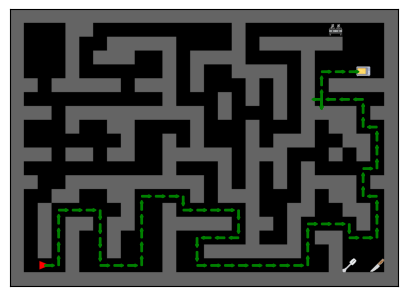

In [110]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)

episodes = sf_df.filter(eval=False, maze_name='big_m3_maze1').episodes
housemaze_analysis.render_path(first(episodes[0]))


In [113]:
housemaze_analysis.make_sf_video(jax.tree_map(lambda x:x[0, 20:], episodes[0]), n=1, line_names=line_names, line_mask=[True, True, False,False]*2)

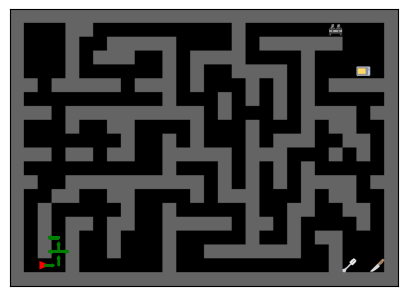

In [92]:
episodes = sf_df.filter(eval=True, maze_name='big_m3_maze1').episodes
housemaze_analysis.render_path(first(episodes[0]))


In [69]:
preds = e.transitions.extras['preds']
jax.tree_map(lambda x:x.shape, preds)

USFAPreds(q_vals=(200, 4), sf=(200, 2, 4, 8), policy=(200, 2, 4, 2), task=(200, 8))

In [91]:
e.timesteps.observation.task_w[0]

Array([1. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ], dtype=float32)

In [76]:
import rlax
sf_values = preds.sf  # [200, 2, 4, 8]
actions = e.actions  # [200]
sf_values = jnp.take_along_axis(sf_values, actions[:, None, None, None], axis=-2)
sf_values = jnp.squeeze(sf_values, axis=-2)

in_episode = housemaze_analysis.get_in_episode(e.timesteps)
sf_values = sf_values[in_episode]
# sf_values.shape  # [61, 2, 8]

# images = e.timesteps

# # index = jax.vmap(rlax.batched_index, in_axes=(3, None), out_axes=1)
# # index = jax.vmap(index, in_axes=(1, None), out_axes=1)
# # sf_values_taken = index(sf_values, actions)
# # sfs = preds.sf[0]  # [200, 2, 4, 8]
# # actions = e.actions[0]  # [200]
# # # index into 3rd dimension with actions
# # sfs_taken = 
# # preds.sf[0,0].shape

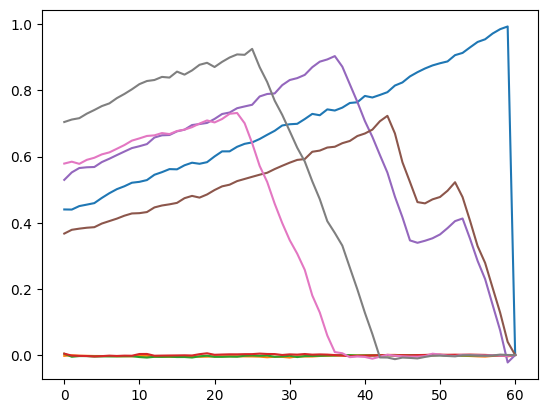

In [61]:
plt.plot(sf_values[:, 0])

### Q-learning

In [10]:
exp = 'exp2'
qlearning_dir = download_data.qlearning_dir
paths = f'{data_dir}/model_data/{qlearning_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='qlearning',
        make_fns=functools.partial(
            housemaze_trainer.get_qlearning_fns,
            num_categories=10000),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    


  0%|          | 0/5 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""qlearning""","""exp2""",0,26,"""big_m1_maze3_shortcut""",3
true,"""qlearning""","""exp2""",0,40,"""big_m1_maze3_shortcut""",3
false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_offpath""",3
true,"""qlearning""","""exp2""",0,40,"""big_m2_maze2_offpath""",3
false,"""qlearning""","""exp2""",0,26,"""big_m3_maze1""",3


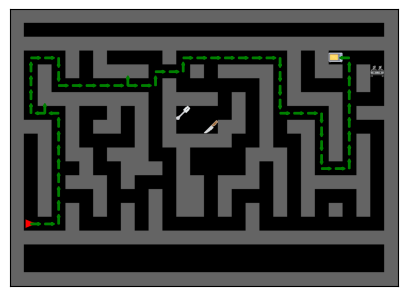

In [11]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### Dyna-Q

In [12]:
exp = 'exp2'
# dyna_dir = f'ql/save_data/ql-21/exp={exp}'
dyna_dir = download_data.dyna_dir
paths = f'{data_dir}/model_data/{dyna_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='dynaq_shared',
        make_fns=functools.partial(housemaze_trainer.get_dynaq_fns,
            env=env,
            env_params=dummy_env_params,
            task_objects=housemaze_analysis.task_objects),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs)
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)



  0%|          | 0/2 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""dynaq_shared""","""exp2""",0,26,"""big_m1_maze3_shortcut""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m1_maze3_shortcut""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m2_maze2_offpath""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m2_maze2_offpath""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m3_maze1""",2


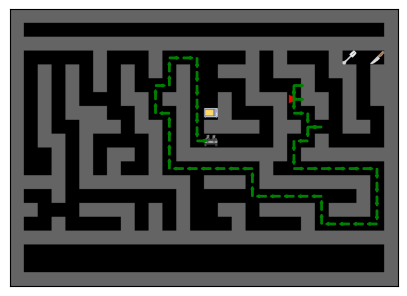

In [13]:
housemaze_analysis.render_path(first(episodes[-1]))
df.head()

### BFS/DFS

In [14]:
for algorithm in ['bfs', 'dfs']:
    df, episodes = housemaze_analysis.get_search_data(
        algorithm=algorithm,
        env=env,
        exp='exp2',
        base_path=f'{data_dir}/search_algos',
        budget=None,
        overwrite=False,
        searches=10,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)

No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/jaxneurorl/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp2""",0,26,null,"""big_m1_maze3_shortcut"""
true,"""dfs""","""exp2""",0,40,null,"""big_m1_maze3_shortcut"""
false,"""dfs""","""exp2""",0,26,null,"""big_m2_maze2_offpath"""
true,"""dfs""","""exp2""",0,40,null,"""big_m2_maze2_offpath"""
false,"""dfs""","""exp2""",0,26,null,"""big_m3_maze1"""


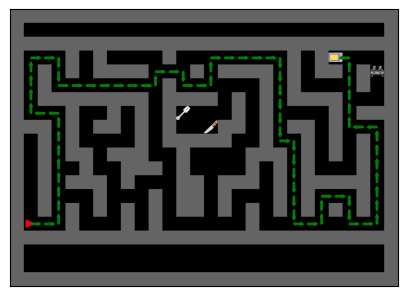

In [15]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()